In [1]:
%matplotlib inline
import sympy
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sympy import Matrix, MatrixSymbol, Symbol, symbols, cos, sin, BlockMatrix
from scipy.linalg import solve_continuous_are
from scipy.signal import place_poles, step, lti
from scipy import signal
from tqdm import tqdm
import code.dynamics as dy
from code.utils import plot_respone
from code.controller import Controller 
import code.systems as Z
from scipy.integrate import solve_ivp
from functools import partial

## Declare the symbols

In [2]:
ctrl = Controller()
x, theta1, theta2, u = (dy.x, dy.theta1, dy.theta2, dy.u)
x_dot, theta1_dot, theta2_dot = (dy.x_dot, dy.theta1_dot, dy. theta2_dot)
x_ddot, theta1_ddot, theta2_ddot = (dy.x_ddot, dy.theta1_ddot, dy. theta2_ddot)
state = Matrix([x,x_dot, theta1, theta1_dot, theta2, theta2_dot])

# variables
m1, m2, M = (dy.m1, dy.m2, dy.M)
l1, l2 = (dy.l1, dy.l2)
g = dy.g

variables = dy.variables

In [3]:
state

Matrix([
[             x],
[       \dot{x}],
[      \theta_1],
[\dot{\theta_1}],
[      \theta_2],
[\dot{\theta_2}]])

In [4]:
N = dy.N #number of tate
R = Matrix([.003])
Q = sympy.eye(N,N)*150

A_sub = dy.A.subs(variables)
B_sub = dy.B.subs(variables)
A_arr = np.array(A_sub,dtype=np.float32)
B_arr = np.array(B_sub,dtype=np.float32)
Q_arr = np.array(Q,dtype=np.float32)
R_arr = np.array(R,dtype=np.float32)

In [18]:
# Lqr Control
K = ctrl.lqr(A_arr,B_arr,Q_arr,R_arr)
K_arr = np.array(K,dtype=np.float32)

## Observability of state space
For 4 different output vector:
* $x(t)$ : Observable
* $\theta_1$ and $\theta_2$ : Not Observable
* $x(t)$ and $\theta_2$ : Observable
* $x(t)$, $\theta_1$ and $\theta_2$ : Observable

In [6]:
C1 = (Matrix([[1,0,0,0,0,0]]),x)
C2 = (Matrix([[0,0,1,0,0,0],[0,0,0,0,1,0]]),(theta1,theta2))
C3 = (Matrix([[1,0,0,0,0,0],[0,0,0,0,1,0]]),(x,theta2))
C4 = (Matrix([[1,0,0,0,0,0],[0,0,1,0,0,0],[0,0,0,0,1,0]]),(x,theta1,theta2))
Cs_temp = [C1,C2,C3,C4]
Cs = []
for c,st in Cs_temp:
    
    observer =  Matrix(BlockMatrix([[c*dy.A**i] for i in range(N)]))
    rk = observer.rank()
    if rk==N:
        # sympy.pprint(st)
        print(f"{st} is observable")
        Cs.append((c,st))
    else:
        print(f"{st} is not observable")

x is observable
(\theta_1, \theta_2) is not observable
(x, \theta_2) is observable
(x, \theta_1, \theta_2) is observable


## Luenberger Observer
tate pace:
$$
\dot X_e(t) = (A-LC)X_e(t) + B_DU_D(t)
$$
For an assumed set of poles (eigenvalues) of $A-LC$ which are on the negative half-plane, the system is stable i.e 
$$
\lambda = [-1,-1.5,-2,-2.5,-3,-3.5]
$$  


In [45]:
# Find the L for above given output vector
# Fixing eigen values for the A-L, we can reversely find L
Ls = []
eig = np.array(Matrix([-1,-1.5,-2, -2.5, -3,-3.5]),dtype=np.float32).reshape(-1,)
for c, st in Cs:
    C_arr = np.array(c.T,dtype=np.float32)
    out = place_poles(A_arr,C_arr,eig)
    O = np.round_(out.gain_matrix,3)
    L = Matrix(O).T
    Ls.append(L)
    # print(sympy.latex(L))

/home/skynet/.local/lib/python3.8/site-packages/scipy/signal/_ltisys.py:3358: UserWarning: Convergence was not reached after maxiter iterations.
You asked for a relative tolerance of 0.001000 we got 1.000000
  warnings.warn(err_msg)


### Non Linear Response of Luenberger Oberver

In [54]:
## Assuming Estimation Error
Est_error_state = Matrix([0,0,0,0,0,0])

## Initializing Input
X_states = {x:0,x_dot:0, theta1:30, theta1_dot:0, theta2:40, theta2_dot:0, u:0}

In [56]:
## Running Luenber Observer and Get Response for 3 observable output vectors
all_step_output = []
all_output_arr_control_observe = []
all_output_arr_control_observe_non_linear = []
all_sys = []
## Auming the initial etimate error to be 100 for all states
states = Matrix(BlockMatrix([[dy.state],[Est_error_state]])) # state with state estimates
for c, l in zip(Cs,Ls):
    output_arr_control_observe, all_states , time_steps, sys = Z.state_space_observer(A_sub,B_sub,c[0],l,K,X_states,states,total_time=500)
    all_output_arr_control_observe.append(output_arr_control_observe)
    t, Y = signal.step2(sys,T=time_steps)
    all_step_output.append(Y)
    all_sys.append(sys)

100%|██████████| 50000/50000 [01:54<00:00, 438.20it/s]


In [48]:
all_output_arr_control_observe[0].shape

(10000,)

### Luenberger Observer Response
For $x(t)$ state

1


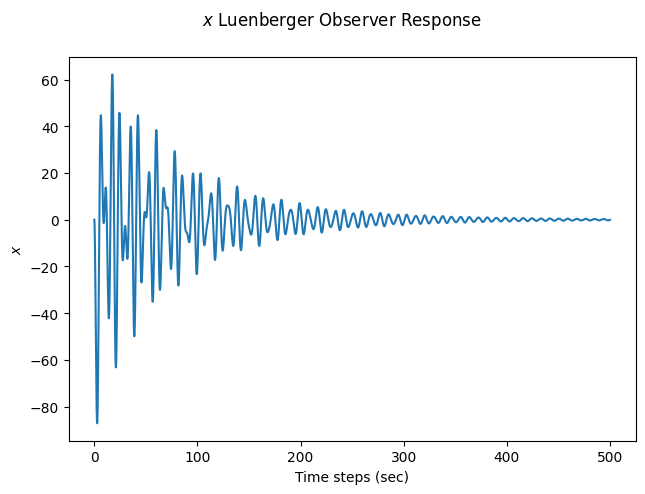

In [62]:
# plot_respone(all_output_arr_control_observe[0],time_steps,N,Cs[0][1],plot_title=f"${Cs[0][1]}$ Luenberger Oberver Response With Estimation Error",Plot_filename="x_Controller+OberverResponse_with_estimation_err", save=True)
plot_respone(all_output_arr_control_observe[0],time_steps,N,Cs[0][1],plot_title=f"${Cs[0][1]}$ Luenberger Observer Response",Plot_filename="x_Controller+OberverResponse", save=True)

### Step Response of Luenberger Observer
For $x(t)$ state

1


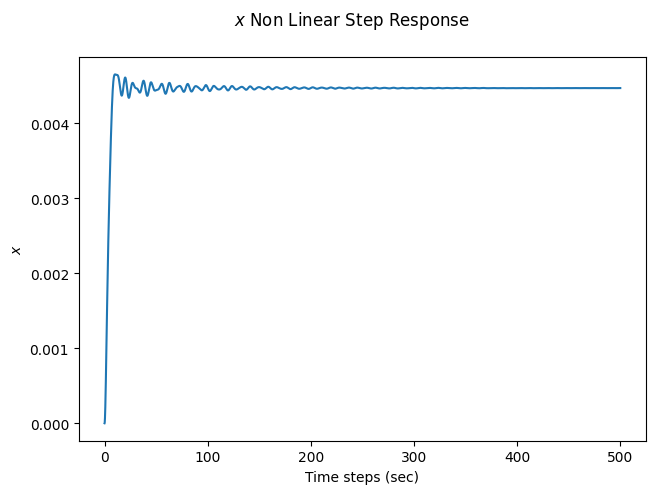

In [18]:
plot_respone(all_step_output[0],time_steps,N,Cs[0][1], plot_title=f"${Cs[0][1]}$ Non Linear Step Response", Plot_filename ="x_Controller+OberverNonLinearStepResponse",save=True)

(50000, 1)
1


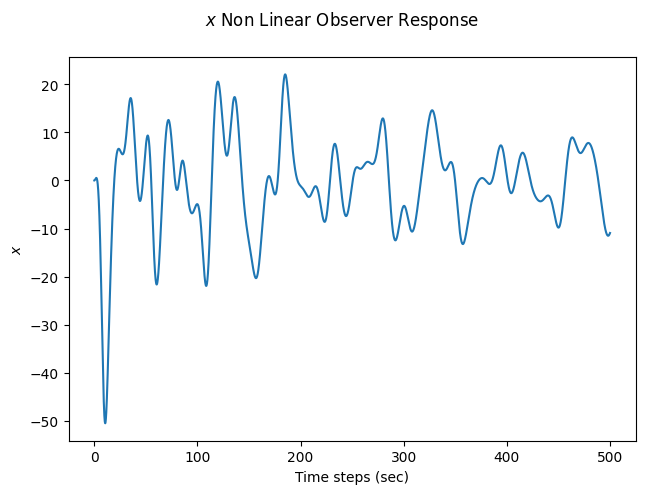

In [70]:
# Non linear response for Luenberger response
i = 0 # 0,1 or 2. 
L_arr = np.array(Ls[i],dtype=np.float32)
C_arr = np.array(Cs[i][0],dtype=np.float32)
A_l = all_sys[0][0]
ode =  ctrl.ode_for_observer(A_l)

Y = np.array([0,0,30,0,40,0,0,0,0,0,0,0]).reshape(-1,)
T = np.linspace(0,500,50000)
# ode(T,Y)
ol = solve_ivp(ode,(0,500),Y,t_eval=T)
time_steps = np.linspace(0,500,ol.y.shape[1])
Y_ARR = ol.y.T[:,:i+1] #np.vstack([ol.y.T[:,0],ol.y.T[:,2],ol.y.T[:,4]])
print(Y_ARR.shape)
plot_respone(Y_ARR,time_steps,N,Cs[i][1],plot_title=f"${Cs[i][1]}$ Non Linear Observer Response",Plot_filename="x_Controller+OberverNonLinearResponse", save=True)

## LQG Controller

Solves the continuous algebraic Riccati equation, or CARE, defined as 
$$AP + PA^T + B_D\Sigma_DB_D^T-PC^T\Sigma_V^{-1}CP = 0$$
directly using a Schur decomposition method.

Then compute $ L = PC^T\Sigma_V^{-1}$ the optimal Obervability Gain Matri solution to LQG Control problem.

In [52]:
# zero mean covariance matrix for state and for output x vector
BdCov_ubBd = np.identity(N) # Process noise covariance
cov_vd = np.array([1]).reshape(1,1) # measurement noise covariance

### Applying LQG for $x(t)$ state for Linear System

In [53]:

## Auming the initial etimate error to be 100 for all states
states = Matrix(BlockMatrix([[dy.state],[Est_error_state]])) # state with state estimates
# states = Matrix(BlockMatrix([[dy.state],[Matrix([0,0,0,0,0,0])]])) # state with state estimates
for c in Cs:
    C_arr = np.array(c[0],dtype=np.float32)
    optimal_L = ctrl.lqg(A_arr.T,C_arr.T,BdCov_ubBd,cov_vd)
    output_arr_control_observe, all_states, time_steps, sys = Z.state_space_observer(A_sub,B_sub,c[0],optimal_L,K,X_states,states,total_time=500)
    break

100%|██████████| 50000/50000 [02:31<00:00, 330.81it/s]


1


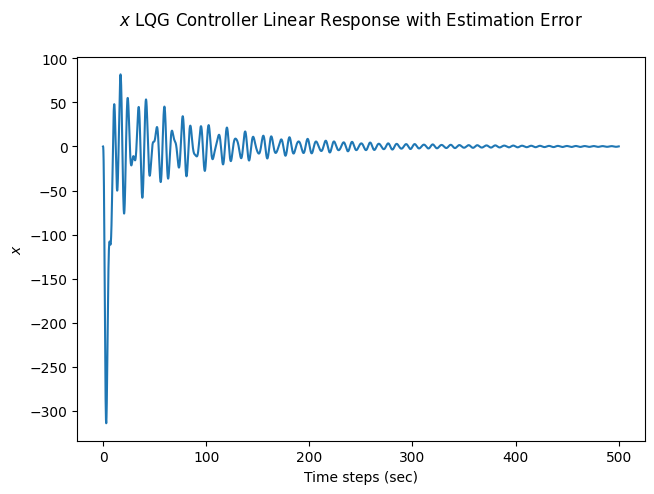

In [46]:
## PLotting Linear Response
plot_respone(all_states[:,0],time_steps,N,Cs[0][1],plot_title=f"${Cs[0][1]}$ LQG Controller Linear Response with Estimation Error",Plot_filename="x_LQG_Controller+OberverLinearResponse_with_etimation_err", save=False)

### Applying LQG for $x(t)$ state for Non Linear System

1


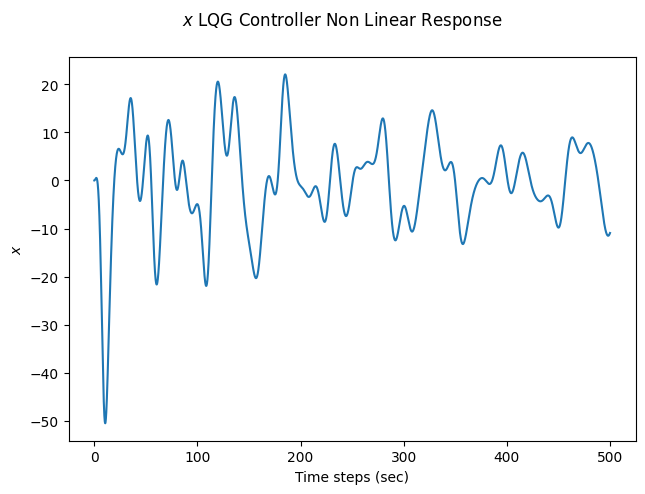

In [50]:
A_lqg = sys[0]
# Non linear plotting
ode = ctrl.ode_for_observer(A_lqg)
Y = np.array([0,0,30,0,40,0,0,0,0,0,0,0]).reshape(-1,)
# Y = np.array([0,0,30,0,40,0,0,0,0,0,0,0]).reshape(-1,)
T = np.linspace(0,500,50000)
# ode(T,Y)
ol = solve_ivp(ode,(0,500),Y,t_eval=T)
time_steps = np.linspace(0,500,ol.y.shape[1])
plot_respone(ol.y.T[:,0],time_steps,N,Cs[0][1],plot_title=f"${Cs[0][1]}$ LQG Controller Non Linear Response",Plot_filename="x_Non Linear LQG Controller Response", save=True)
# plot_respone(ol.y.T,time_steps,N,state,plot_title="Non Linear LQG  Controller Response", Plot_filename="Non Linear LQG Controller Response",save=False)